In [2]:
# load libraries

import nilearn.plotting as plotting
import nilearn.image as image
from nilearn import datasets
import nibabel as nib
import matplotlib.pyplot as plt


In [24]:
# Load the image with nibabel
atlas_img = nib.load(msdl_atlas_img)

# Save it as a NIfTI file
nib.save(atlas_img, 'msdl_atlas.nii.gz')

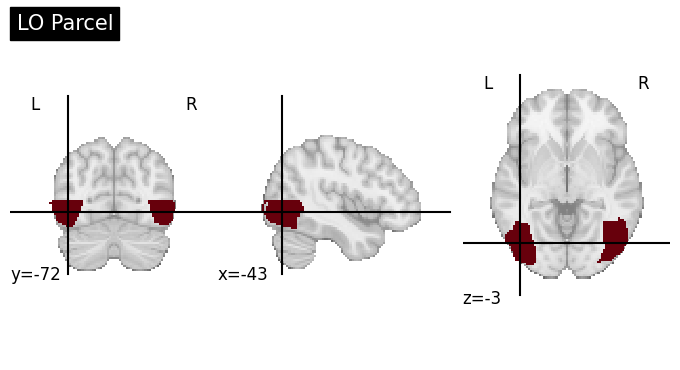

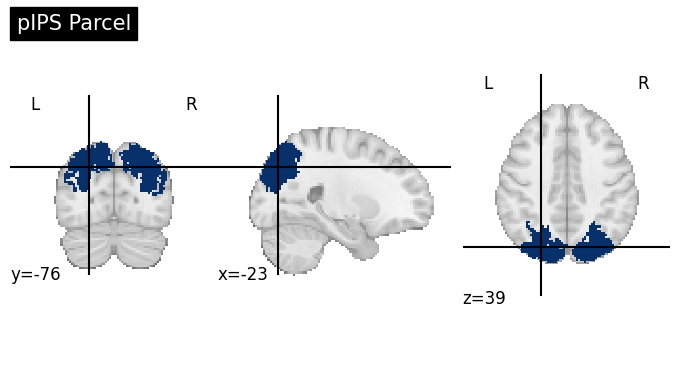

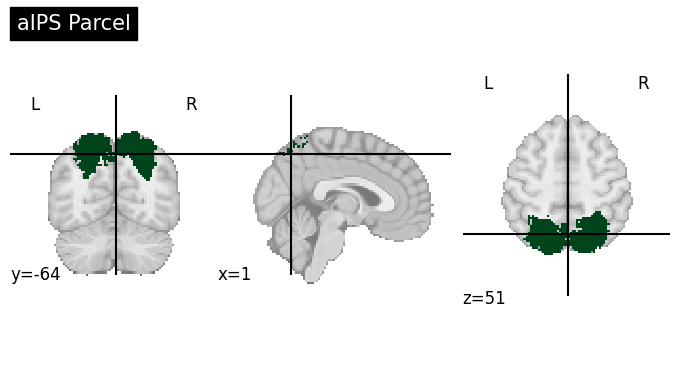

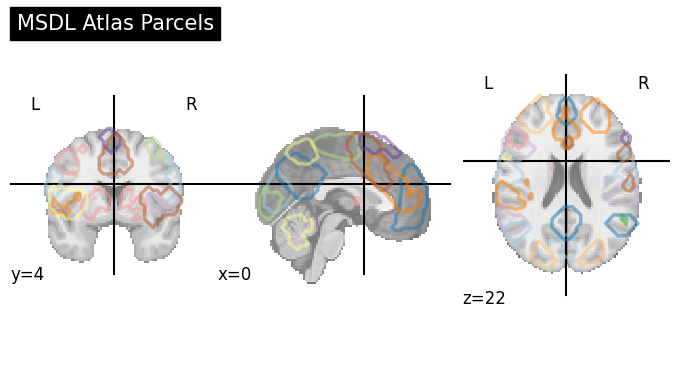

In [21]:
from nilearn import plotting, datasets
import nibabel as nib

# Load each parcel
parcel_lo = nib.load('roiParcels/LO.nii.gz')
parcel_pips = nib.load('roiParcels/pIPS.nii.gz')
parcel_aips = nib.load('roiParcels/aIPS.nii.gz')

# Plot each Julian/Mruczek parcel with colors
plotting.plot_stat_map(parcel_lo, title="LO Parcel", colorbar=False, cmap='Reds', threshold=0.1)
plotting.plot_stat_map(parcel_pips, title="pIPS Parcel", colorbar=False, cmap='Blues', threshold=0.1)
plotting.plot_stat_map(parcel_aips, title="aIPS Parcel", colorbar=False, cmap='Greens', threshold=0.1)

# Load and plot all MSDL atlas parcels
msdl_atlas = datasets.fetch_atlas_msdl()
msdl_atlas_img = msdl_atlas['maps']
plotting.plot_prob_atlas(msdl_atlas_img, title="MSDL Atlas Parcels", cmap="Paired", alpha=0.5)

plotting.show()


2024-11-14 17:53:01,279 - INFO - Saved mapping to /user_data/csimmon2/git_repos/ptoc/results/visual_parcels_mapping/visual_parcels_to_schaefer_mapping.csv
2024-11-14 17:53:01,287 - INFO - Plotting original parcels...


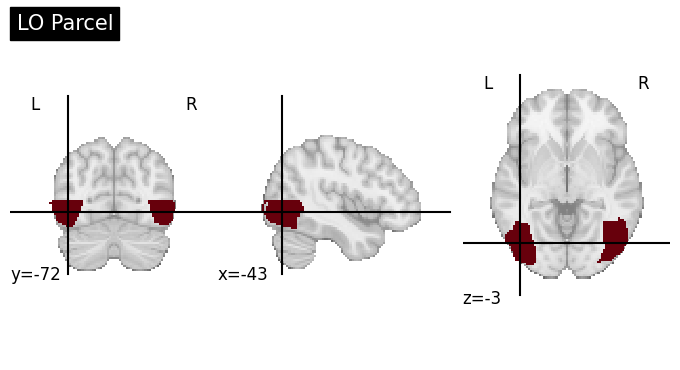

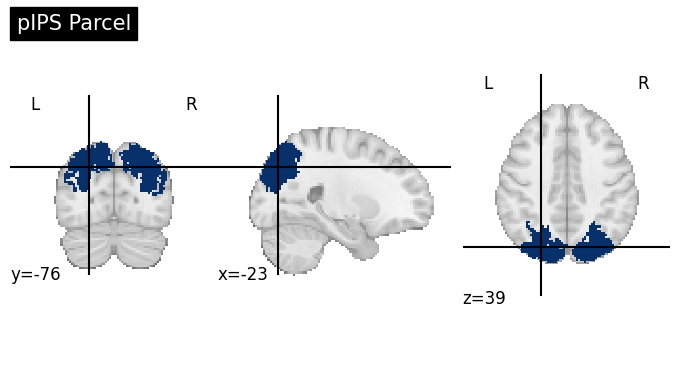

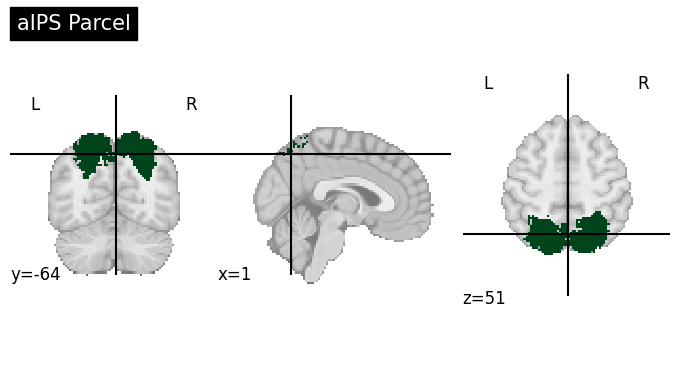

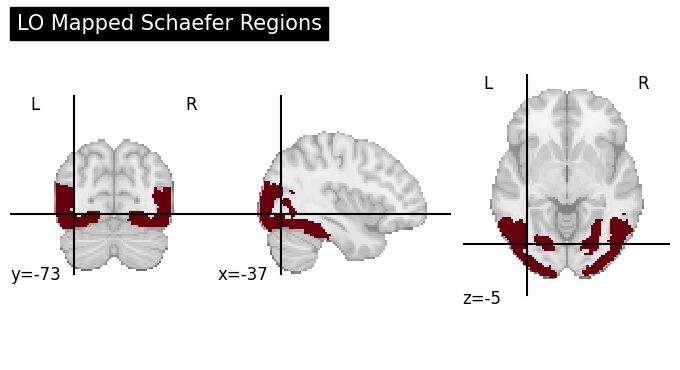

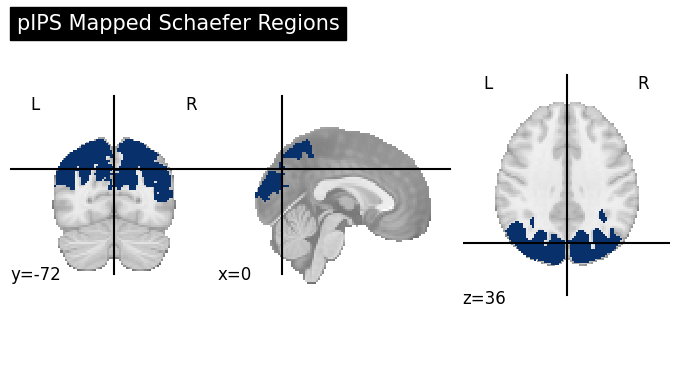

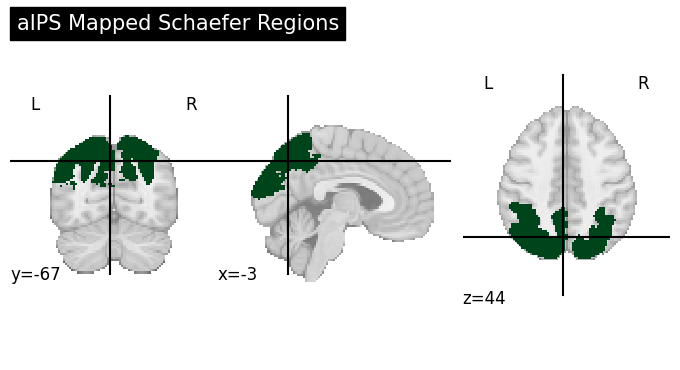

In [7]:
import os
import sys
import pandas as pd
import numpy as np
import nibabel as nib
from nilearn import plotting, datasets
import logging

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Import your parameters
curr_dir = f'/user_data/csimmon2/git_repos/ptoc'
sys.path.insert(0, curr_dir)
import ptoc_params as params

# Set up directories
results_dir = '/user_data/csimmon2/git_repos/ptoc/results'

def load_visual_parcels():
    """Load the Mruczek/Julian parcels"""
    parcels = {
        'LO': nib.load('roiParcels/LO.nii.gz'),
        'pIPS': nib.load('roiParcels/pIPS.nii.gz'),
        'aIPS': nib.load('roiParcels/aIPS.nii.gz')
    }
    return parcels

def find_overlapping_regions(parcel_img, atlas_img, atlas_labels, overlap_threshold=0.1):
    """
    Find Schaefer regions that overlap with a given parcel
    
    Parameters:
    -----------
    parcel_img : nibabel.Nifti1Image
        The parcel image
    atlas_img : nibabel.Nifti1Image
        The Schaefer atlas image
    atlas_labels : list
        List of Schaefer region labels
    overlap_threshold : float
        Minimum overlap fraction to consider (0-1)
        
    Returns:
    --------
    list of dicts
        Each dict contains region index, name, and overlap percentage
    """
    parcel_data = parcel_img.get_fdata()
    atlas_data = atlas_img.get_fdata()
    
    # Get parcel voxels
    parcel_voxels = parcel_data > 0
    parcel_volume = np.sum(parcel_voxels)
    
    overlapping_regions = []
    
    # Check each atlas region
    for i, label in enumerate(atlas_labels):
        if i == 0:  # Skip background
            continue
            
        # Get atlas region voxels
        region_voxels = atlas_data == i
        
        # Calculate overlap
        overlap_voxels = np.sum(np.logical_and(parcel_voxels, region_voxels))
        if overlap_voxels > 0:
            overlap_percentage = (overlap_voxels / parcel_volume) * 100
            
            if overlap_percentage >= overlap_threshold:
                overlapping_regions.append({
                    'region_index': i,
                    'region_name': label,
                    'overlap_percentage': overlap_percentage
                })
    
    return overlapping_regions

def create_mapping(n_rois=200):
    """Create mapping between visual parcels and Schaefer atlas"""
    # Load atlases
    visual_parcels = load_visual_parcels()
    schaefer = datasets.fetch_atlas_schaefer_2018(n_rois=n_rois, yeo_networks=7, resolution_mm=2)
    schaefer_img = nib.load(schaefer.maps)
    
    # Create mapping
    mapping = []
    for parcel_name, parcel_img in visual_parcels.items():
        overlapping = find_overlapping_regions(parcel_img, schaefer_img, schaefer.labels)
        
        for region in overlapping:
            mapping.append({
                'visual_parcel': parcel_name,
                'schaefer_index': region['region_index'],
                'schaefer_region': region['region_name'],
                'overlap_percentage': region['overlap_percentage']
            })
    
    return pd.DataFrame(mapping)

def plot_mapping_results():
    """Plot original parcels and their Schaefer mappings"""
    # Load parcels
    parcels = load_visual_parcels()
    
    # Plot original parcels
    logging.info("Plotting original parcels...")
    plotting.plot_stat_map(
        parcels['LO'],
        title="LO Parcel",
        colorbar=False,
        cmap='Reds',
        threshold=0.1,
        display_mode='ortho'
    )
    
    plotting.plot_stat_map(
        parcels['pIPS'],
        title="pIPS Parcel",
        colorbar=False,
        cmap='Blues',
        threshold=0.1,
        display_mode='ortho'
    )
    
    plotting.plot_stat_map(
        parcels['aIPS'],
        title="aIPS Parcel",
        colorbar=False,
        cmap='Greens',
        threshold=0.1,
        display_mode='ortho'
    )
    
    # Get mapping
    mapping_df = create_mapping()
    
    # Load Schaefer atlas
    schaefer = datasets.fetch_atlas_schaefer_2018(n_rois=200, yeo_networks=7, resolution_mm=2)
    schaefer_img = nib.load(schaefer.maps)
    
    # Create masked Schaefer images for each parcel
    for parcel_name in ['LO', 'pIPS', 'aIPS']:
        # Get indices for this parcel
        parcel_regions = mapping_df[mapping_df['visual_parcel'] == parcel_name]['schaefer_index'].values
        
        if len(parcel_regions) > 0:
            # Create masked image
            mask = np.zeros_like(schaefer_img.get_fdata())
            for idx in parcel_regions:
                mask[schaefer_img.get_fdata() == idx] = 1
                
            masked_img = nib.Nifti1Image(mask, schaefer_img.affine)
            
            # Plot
            cmap = 'Reds' if parcel_name == 'LO' else 'Blues' if parcel_name == 'pIPS' else 'Greens'
            plotting.plot_stat_map(
                masked_img,
                title=f"{parcel_name} Mapped Schaefer Regions",
                colorbar=False,
                cmap=cmap,
                threshold=0.1,
                display_mode='ortho'
            )

def main():
    # Create output directory
    output_dir = f'{results_dir}/visual_parcels_mapping'
    os.makedirs(output_dir, exist_ok=True)
    
    # Create mapping
    mapping_df = create_mapping()
    
    # Save mapping
    mapping_df.to_csv(f'{output_dir}/visual_parcels_to_schaefer_mapping.csv', index=False)
    logging.info(f"Saved mapping to {output_dir}/visual_parcels_to_schaefer_mapping.csv")
    
    # Plot results
    plot_mapping_results()
    plotting.show()

if __name__ == "__main__":
    main()

In [8]:
import nibabel as nib
import numpy as np
from nilearn import datasets
import pandas as pd
import logging

def identify_schaefer_rois(parcel_path, n_rois=200, overlap_threshold=0.1):
    """
    Identify which Schaefer ROIs overlap with a given parcel
    
    Parameters:
    -----------
    parcel_path : str
        Path to the parcel nifti file
    n_rois : int
        Number of ROIs in Schaefer atlas (200, 400, or 1000)
    overlap_threshold : float
        Minimum overlap to consider (0-1)
        
    Returns:
    --------
    dict : Dictionary containing ROI indices and names that overlap with the parcel
    """
    # Load the parcel
    parcel_img = nib.load(parcel_path)
    parcel_data = parcel_img.get_fdata()
    
    # Load Schaefer atlas
    schaefer = datasets.fetch_atlas_schaefer_2018(n_rois=n_rois, yeo_networks=7, resolution_mm=2)
    atlas_img = nib.load(schaefer.maps)
    atlas_data = atlas_img.get_fdata()
    
    # Find overlapping ROIs
    overlapping_rois = []
    
    # Get parcel voxels
    parcel_voxels = parcel_data > 0
    
    # Check each Schaefer ROI
    for i in range(1, n_rois + 1):  # Schaefer ROIs are 1-indexed
        # Get ROI voxels
        roi_voxels = atlas_data == i
        
        # Calculate overlap
        overlap = np.logical_and(parcel_voxels, roi_voxels)
        if np.any(overlap):
            overlap_ratio = np.sum(overlap) / np.sum(parcel_voxels)
            
            if overlap_ratio >= overlap_threshold:
                overlapping_rois.append({
                    'roi_index': i-1,  # Convert to 0-based index for connectivity matrices
                    'roi_name': schaefer.labels[i-1],
                    'overlap_ratio': overlap_ratio
                })
    
    return overlapping_rois

def main():
    # Paths to your parcels
    parcels = {
        'LO': 'roiParcels/LO.nii.gz',
        'pIPS': 'roiParcels/pIPS.nii.gz',
        'aIPS': 'roiParcels/aIPS.nii.gz'
    }
    
    # Create mapping for each parcel
    all_mappings = []
    
    for parcel_name, parcel_path in parcels.items():
        overlapping_rois = identify_schaefer_rois(parcel_path)
        
        for roi in overlapping_rois:
            all_mappings.append({
                'parcel': parcel_name,
                'schaefer_index': roi['roi_index'],  # 0-based index
                'schaefer_name': roi['roi_name'],
                'overlap_ratio': roi['overlap_ratio']
            })
    
    # Convert to DataFrame
    mapping_df = pd.DataFrame(all_mappings)
    
    # Print results
    print("\nIdentified Schaefer ROIs for each parcel:")
    for parcel_name in parcels.keys():
        parcel_rois = mapping_df[mapping_df['parcel'] == parcel_name]
        print(f"\n{parcel_name} Parcel corresponds to these Schaefer ROIs:")
        for _, roi in parcel_rois.iterrows():
            print(f"Index {roi['schaefer_index']}: {roi['schaefer_name']} "
                  f"(overlap: {roi['overlap_ratio']:.2%})")
    
    # Save mapping
    mapping_df.to_csv('schaefer_roi_mapping.csv', index=False)
    print(f"\nMapping saved to schaefer_roi_mapping.csv")
    
    return mapping_df

if __name__ == "__main__":
    mapping_df = main()


Identified Schaefer ROIs for each parcel:

LO Parcel corresponds to these Schaefer ROIs:
Index 2: b'7Networks_LH_Vis_3' (overlap: 15.43%)
Index 104: b'7Networks_RH_Vis_5' (overlap: 14.44%)

pIPS Parcel corresponds to these Schaefer ROIs:
Index 114: b'7Networks_RH_Vis_15' (overlap: 10.53%)

aIPS Parcel corresponds to these Schaefer ROIs:

Mapping saved to schaefer_roi_mapping.csv



Schaefer Atlas Properties:
Shape: (91, 109, 91)
Affine:
[[  -2.    0.    0.   90.]
 [   0.    2.    0. -126.]
 [   0.    0.    2.  -72.]
 [   0.    0.    0.    1.]]
Voxel sizes: (2.0, 2.0, 2.0)

Checking LO parcel...

Properties for roiParcels/LO.nii.gz:
Shape: (91, 109, 91)
Affine:
[[  -2.    0.    0.   90.]
 [   0.    2.    0. -126.]
 [   0.    0.    2.  -72.]
 [   0.    0.    0.    1.]]
Header info:
  Voxel sizes: (2.0, 2.0, 2.0)
  Units: ('unknown', 'unknown')
  Number of non-zero voxels: 4245
  Data type: uint8
  Value range: [0.0, 1.0]
  Format: Volumetric (3D)

Checking pIPS parcel...

Properties for roiParcels/pIPS.nii.gz:
Shape: (91, 109, 91)
Affine:
[[  -2.    0.    0.   90.]
 [   0.    2.    0. -126.]
 [   0.    0.    2.  -72.]
 [   0.    0.    0.    1.]]
Header info:
  Voxel sizes: (2.0, 2.0, 2.0)
  Units: ('unknown', 'unknown')
  Number of non-zero voxels: 7343
  Data type: float32
  Value range: [0.0, 1.0]
  Format: Volumetric (3D)

Checking aIPS parcel...

Properties fo

/home/csimmon2/anaconda3/envs/network/lib/python3.8/site-packages/numpy/ma/core.py:2820: UserWarning: Warning: converting a masked element to nan.
  _data = np.array(data, dtype=dtype, copy=copy,


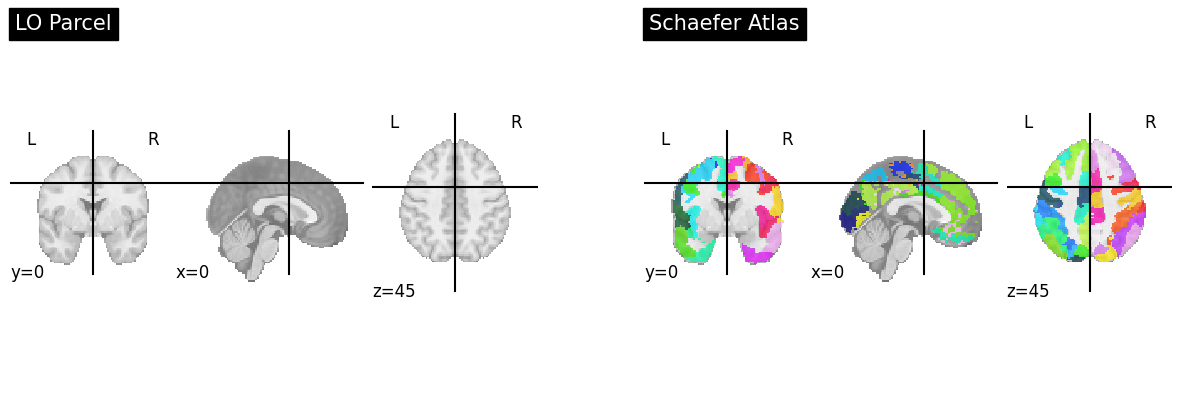

In [9]:
import nibabel as nib
import numpy as np
from nilearn import datasets
import pandas as pd
import logging

def check_image_properties(img_path):
    """Print detailed information about a nifti image"""
    img = nib.load(img_path)
    data = img.get_fdata()
    
    print(f"\nProperties for {img_path}:")
    print(f"Shape: {img.shape}")
    print(f"Affine:\n{img.affine}")
    print(f"Header info:")
    print(f"  Voxel sizes: {img.header.get_zooms()}")
    print(f"  Units: {img.header.get_xyzt_units()}")
    print(f"  Number of non-zero voxels: {np.sum(data > 0)}")
    print(f"  Data type: {img.get_data_dtype()}")
    print(f"  Value range: [{data.min()}, {data.max()}]")
    
    # Check if volumetric or surface
    if len(img.shape) == 3:
        print("  Format: Volumetric (3D)")
    elif len(img.shape) == 2:
        print("  Format: Surface (2D)")
    else:
        print(f"  Format: Unknown ({len(img.shape)}D)")
        
    return img

def compare_with_schaefer():
    """Compare Mruczek parcels with Schaefer atlas"""
    # Load Schaefer atlas
    schaefer = datasets.fetch_atlas_schaefer_2018(n_rois=200, yeo_networks=7, resolution_mm=2)
    schaefer_img = nib.load(schaefer.maps)
    
    print("\nSchaefer Atlas Properties:")
    print(f"Shape: {schaefer_img.shape}")
    print(f"Affine:\n{schaefer_img.affine}")
    print(f"Voxel sizes: {schaefer_img.header.get_zooms()}")
    
    # Check each Mruczek parcel
    parcels = {
        'LO': 'roiParcels/LO.nii.gz',
        'pIPS': 'roiParcels/pIPS.nii.gz',
        'aIPS': 'roiParcels/aIPS.nii.gz'
    }
    
    mruczek_imgs = {}
    for name, path in parcels.items():
        print(f"\nChecking {name} parcel...")
        mruczek_imgs[name] = check_image_properties(path)
    
    # Compare spaces
    print("\nSpace Comparison:")
    for name, img in mruczek_imgs.items():
        print(f"\n{name} vs Schaefer:")
        print(f"Shape match: {img.shape == schaefer_img.shape}")
        print(f"Affine match: {np.allclose(img.affine, schaefer_img.affine, atol=1e-3)}")
        print(f"Voxel size match: {np.allclose(img.header.get_zooms(), schaefer_img.header.get_zooms(), atol=1e-3)}")

def main():
    logging.basicConfig(level=logging.INFO)
    compare_with_schaefer()
    
    # Additional visualization of overlap
    import matplotlib.pyplot as plt
    from nilearn import plotting
    
    # Load images
    schaefer = datasets.fetch_atlas_schaefer_2018(n_rois=200, yeo_networks=7, resolution_mm=2)
    schaefer_img = nib.load(schaefer.maps)
    lo_img = nib.load('roiParcels/LO.nii.gz')
    
    # Create figure
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot mid slices
    mid_z = schaefer_img.shape[2] // 2
    
    plotting.plot_roi(
        lo_img,
        title="LO Parcel",
        cut_coords=(0, 0, mid_z),
        display_mode='ortho',
        axes=ax1
    )
    
    plotting.plot_roi(
        schaefer_img,
        title="Schaefer Atlas",
        cut_coords=(0, 0, mid_z),
        display_mode='ortho',
        axes=ax2
    )
    
    plt.show()

if __name__ == "__main__":
    main()

In [14]:
# generate schaefer 200 roi list || compared to visual parcels

import nibabel as nib
import numpy as np
from nilearn import datasets
import pandas as pd

def get_schaefer_rois(parcel_path):
    """Get Schaefer 200 ROIs that overlap with a given parcel"""
    # Load the parcel
    parcel_img = nib.load(parcel_path)
    parcel_data = parcel_img.get_fdata()
    parcel_volume = np.sum(parcel_data > 0)
    
    # Load Schaefer atlas
    schaefer = datasets.fetch_atlas_schaefer_2018(n_rois=200, yeo_networks=7, resolution_mm=2)
    atlas_img = nib.load(schaefer.maps)
    atlas_data = atlas_img.get_fdata()
    
    # Find overlapping ROIs
    overlapping_rois = []
    covered_voxels = set()
    parcel_coords = set(map(tuple, np.array(np.where(parcel_data > 0)).T))
    
    # Check each ROI
    for i in range(1, 201):  # Schaefer 200 ROIs
        roi_mask = atlas_data == i
        intersection = np.logical_and(parcel_data > 0, roi_mask)
        
        if np.any(intersection):
            intersection_volume = np.sum(intersection)
            overlap_percentage = intersection_volume / parcel_volume
            
            roi_coords = set(map(tuple, np.array(np.where(roi_mask)).T))
            new_coverage = roi_coords.intersection(parcel_coords) - covered_voxels
            unique_coverage = len(new_coverage) / parcel_volume
            
            if unique_coverage >= 0.005:  # At least 0.5% new coverage
                covered_voxels.update(new_coverage)
                overlapping_rois.append({
                    'roi_index': i-1,  # Convert to 0-based for connectivity matrices
                    'roi_name': schaefer.labels[i-1].decode(),
                    'network': schaefer.labels[i-1].decode().split('_')[2],
                    'overlap_percentage': overlap_percentage * 100,
                    'unique_coverage': unique_coverage * 100
                })
    
    # Sort by overlap percentage
    overlapping_rois.sort(key=lambda x: x['overlap_percentage'], reverse=True)
    return overlapping_rois

def main():
    parcels = {
        'LO': 'roiParcels/LO.nii.gz',
        'pIPS': 'roiParcels/pIPS.nii.gz',
        'aIPS': 'roiParcels/aIPS.nii.gz'
    }
    
    # Store all results
    all_results = []
    
    print("\nDetailed ROI List for Each Parcel:")
    print("=" * 80)
    
    for parcel_name, parcel_path in parcels.items():
        print(f"\n{parcel_name} Parcel ROIs:")
        print("-" * 40)
        
        rois = get_schaefer_rois(parcel_path)
        
        # Group ROIs by network
        network_rois = {}
        for roi in rois:
            network = roi['network']
            if network not in network_rois:
                network_rois[network] = []
            network_rois[network].append(roi)
        
        # Print results grouped by network
        for network, network_rois_list in network_rois.items():
            print(f"\n{network} Network:")
            for roi in network_rois_list:
                print(f"Index {roi['roi_index']}: {roi['roi_name']}")
                print(f"  Overlap: {roi['overlap_percentage']:.1f}%")
                print(f"  Unique Coverage: {roi['unique_coverage']:.1f}%")
        
        # Add to overall results
        for roi in rois:
            roi['parcel'] = parcel_name
            all_results.append(roi)
        
        # Print summary
        total_coverage = sum(roi['unique_coverage'] for roi in rois)
        print(f"\nTotal ROIs for {parcel_name}: {len(rois)}")
        print(f"Total Coverage: {total_coverage:.1f}%")
        
        # Print indices in a format easy to copy for numpy indexing
        indices = [roi['roi_index'] for roi in rois]
        print("\nROI indices for connectivity matrices:")
        print(f"indices_{parcel_name.lower()} = [{', '.join(map(str, indices))}]")
    
    # Save to CSV
    df = pd.DataFrame(all_results)
    df.to_csv('schaefer200_roi_mapping_detailed.csv', index=False)
    
    # Create a more concise summary DataFrame
    summary = []
    for parcel_name in parcels.keys():
        parcel_rois = [r for r in all_results if r['parcel'] == parcel_name]
        networks = set(r['network'] for r in parcel_rois)
        
        for network in networks:
            network_rois = [r for r in parcel_rois if r['network'] == network]
            network_coverage = sum(r['unique_coverage'] for r in network_rois)
            
            summary.append({
                'parcel': parcel_name,
                'network': network,
                'n_rois': len(network_rois),
                'coverage': network_coverage
            })
    
    summary_df = pd.DataFrame(summary)
    print("\nNetwork Coverage Summary:")
    print(summary_df.to_string())
    summary_df.to_csv('schaefer200_network_summary.csv', index=False)

if __name__ == "__main__":
    main()


Detailed ROI List for Each Parcel:

LO Parcel ROIs:
----------------------------------------

Vis Network:
Index 2: 7Networks_LH_Vis_3
  Overlap: 15.4%
  Unique Coverage: 15.4%
Index 104: 7Networks_RH_Vis_5
  Overlap: 14.4%
  Unique Coverage: 14.4%
Index 7: 7Networks_LH_Vis_8
  Overlap: 5.5%
  Unique Coverage: 5.5%
Index 10: 7Networks_LH_Vis_11
  Overlap: 4.5%
  Unique Coverage: 4.5%
Index 110: 7Networks_RH_Vis_11
  Overlap: 3.2%
  Unique Coverage: 3.2%
Index 107: 7Networks_RH_Vis_8
  Overlap: 3.0%
  Unique Coverage: 3.0%
Index 1: 7Networks_LH_Vis_2
  Overlap: 2.9%
  Unique Coverage: 2.9%
Index 102: 7Networks_RH_Vis_3
  Overlap: 2.7%
  Unique Coverage: 2.7%
Index 4: 7Networks_LH_Vis_5
  Overlap: 2.1%
  Unique Coverage: 2.1%
Index 8: 7Networks_LH_Vis_9
  Overlap: 1.6%
  Unique Coverage: 1.6%

DorsAttn Network:
Index 134: 7Networks_RH_DorsAttn_Post_1
  Overlap: 7.2%
  Unique Coverage: 7.2%
Index 135: 7Networks_RH_DorsAttn_Post_2
  Overlap: 6.8%
  Unique Coverage: 6.8%
Index 31: 7Network

/tmp/ipykernel_23542/2776257889.py:84: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/tmp/ipykernel_23542/2776257889.py:126: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


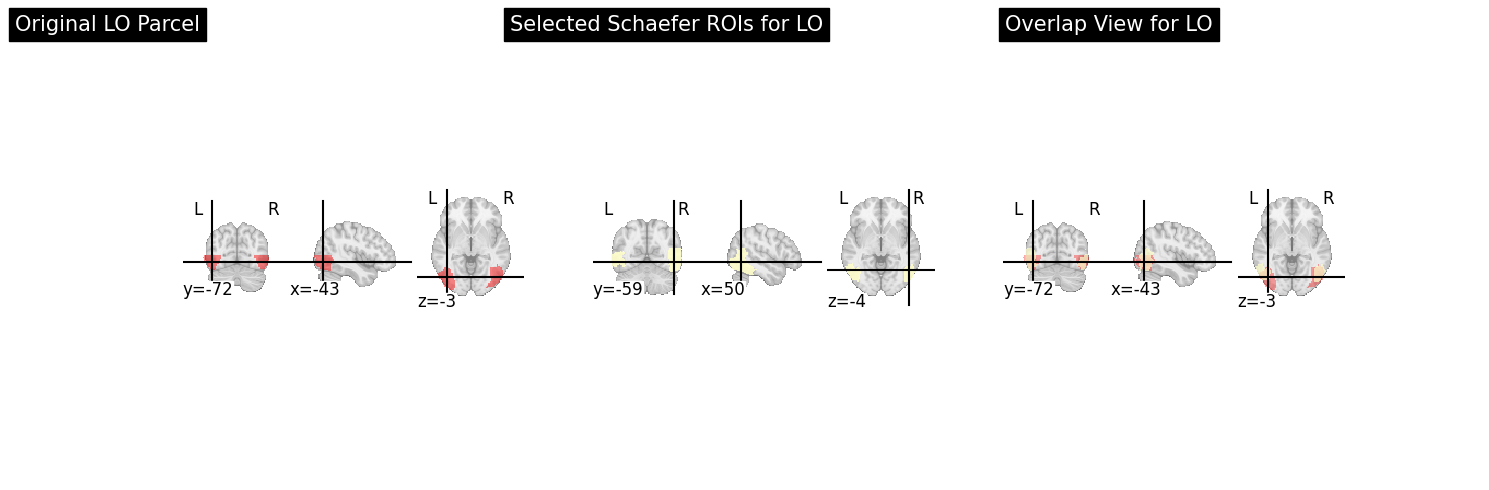

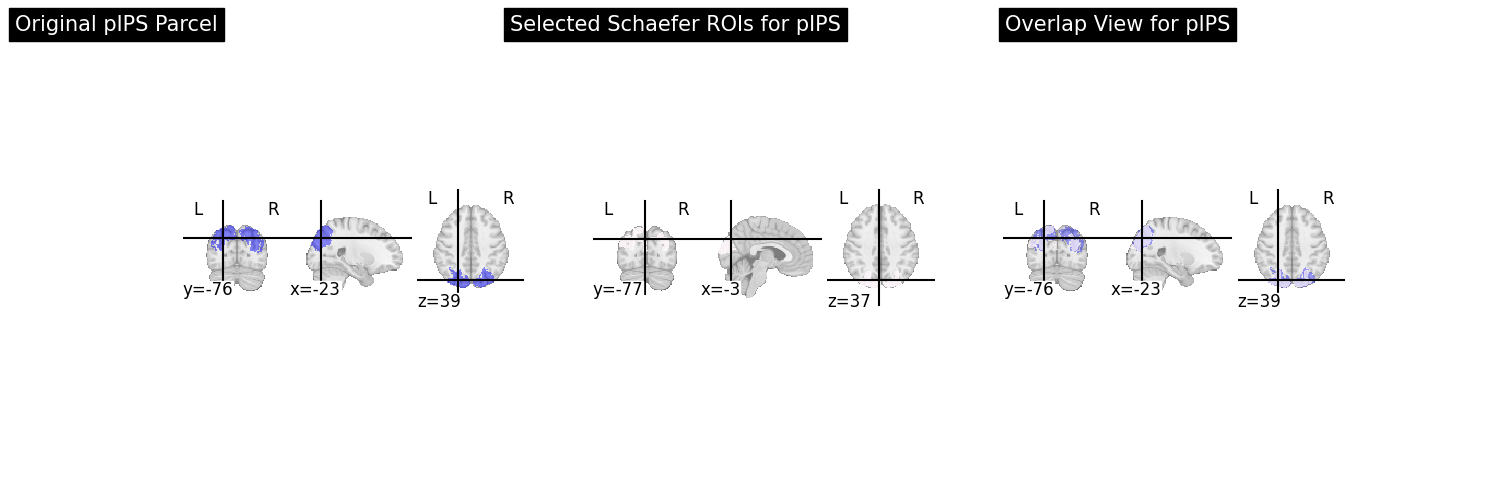

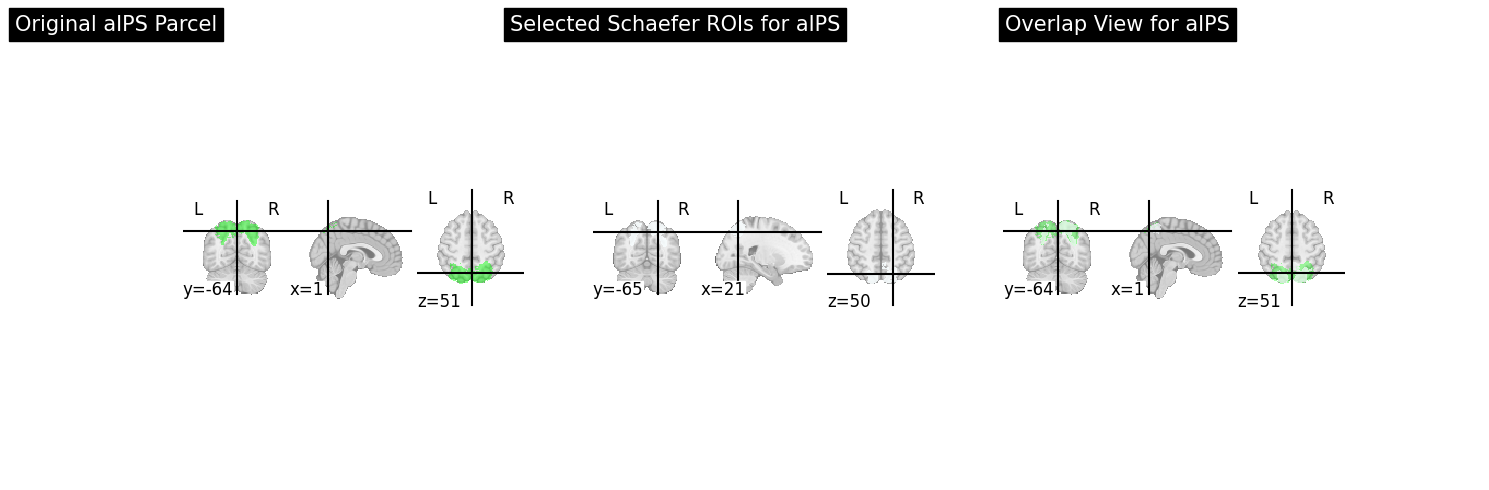

In [21]:
# visualizing selected ROIs
import nibabel as nib
import numpy as np
from nilearn import datasets, plotting
import matplotlib.pyplot as plt

def create_selected_schaefer_mask(selected_indices, schaefer_img):
    """Create a mask of only the selected Schaefer ROIs"""
    schaefer_data = schaefer_img.get_fdata()
    mask = np.zeros_like(schaefer_data)
    
    for idx in selected_indices:
        mask[schaefer_data == (idx + 1)] = 1  # Add 1 because Schaefer ROIs are 1-based
        
    return nib.Nifti1Image(mask, schaefer_img.affine)

def visualize_overlap():
    # Load Schaefer atlas
    schaefer = datasets.fetch_atlas_schaefer_2018(n_rois=200, yeo_networks=7, resolution_mm=2)
    schaefer_img = nib.load(schaefer.maps)
    
    # Load Mruczek parcels
    parcels = {
        'LO': {'file': 'roiParcels/LO.nii.gz', 'color': 'Reds', 'indices': []},
        'pIPS': {'file': 'roiParcels/pIPS.nii.gz', 'color': 'Blues', 'indices': []},
        'aIPS': {'file': 'roiParcels/aIPS.nii.gz', 'color': 'Greens', 'indices': []}
    }
    
    # Get selected ROI indices for each parcel
    # Replace these with your actual indices from the previous analysis
    parcels['LO']['indices'] = [2, 104, 134, 135, 7, 31]  # Example indices
    parcels['pIPS']['indices'] = [114, 36, 32, 13, 79, 141, 12, 113]  # Example indices
    parcels['aIPS']['indices'] = [141, 36, 114, 32, 142, 139]  # Example indices
    
    # Create separate figures for each parcel
    for parcel_name, parcel_info in parcels.items():
        # Load parcel
        parcel_img = nib.load(parcel_info['file'])
        
        # Create mask of selected Schaefer ROIs
        selected_rois = create_selected_schaefer_mask(parcel_info['indices'], schaefer_img)
        
        # Create figure with multiple views
        fig = plt.figure(figsize=(15, 5))
        
        # Plot original parcel
        ax1 = plt.subplot(131)
        display1 = plotting.plot_roi(
            parcel_img,
            title=f"Original {parcel_name} Parcel",
            colorbar=False,
            cmap=plotting.cm.red_transparent if parcel_name == 'LO' else plotting.cm.blue_transparent if parcel_name == 'pIPS' else plotting.cm.green_transparent,
            alpha=0.9,
            axes=ax1
        )
        
        # Plot selected Schaefer ROIs
        ax2 = plt.subplot(132)
        display2 = plotting.plot_roi(
            selected_rois,
            title=f"Selected Schaefer ROIs for {parcel_name}",
            colorbar=False,
            cmap='YlOrRd' if parcel_name == 'LO' else 'PuBu' if parcel_name == 'pIPS' else 'BuGn',
            alpha=0.9,
            axes=ax2
        )
        
        # Plot overlap
        ax3 = plt.subplot(133)
        display3 = plotting.plot_roi(
            parcel_img,
            title=f"Overlap View for {parcel_name}",
            colorbar=False,
            cmap=plotting.cm.red_transparent if parcel_name == 'LO' else plotting.cm.blue_transparent if parcel_name == 'pIPS' else plotting.cm.green_transparent,
            alpha=0.7,
            axes=ax3
        )
        display3.add_overlay(
            selected_rois,
            cmap='YlOrRd' if parcel_name == 'LO' else 'PuBu' if parcel_name == 'pIPS' else 'BuGn',
            alpha=0.7
        )
        
        plt.tight_layout()
        plt.savefig(f'{parcel_name}_schaefer_overlap.png', dpi=300, bbox_inches='tight')
        #plt.close()
        
        # Create additional multi-slice view
        fig, axes = plt.subplots(2, 1, figsize=(15, 10))
        fig.suptitle(f"{parcel_name} Parcel - Multi-slice View", y=0.95)
        
        # Sagittal view with multiple slices
        display4 = plotting.plot_roi(
            parcel_img,
            display_mode='x',
            cut_coords=5,  # Show 5 sagittal slices
            colorbar=False,
            cmap=parcel_info['color'],
            alpha=0.5,
            title="Sagittal View",
            axes=axes[0]
        )
        display4.add_overlay(
            selected_rois,
            cmap='Set2',
            alpha=0.5
        )
        
        # Axial view with multiple slices
        display5 = plotting.plot_roi(
            parcel_img,
            display_mode='z',
            cut_coords=5,  # Show 5 axial slices
            colorbar=False,
            cmap=parcel_info['color'],
            alpha=0.5,
            title="Axial View",
            axes=axes[1]
        )
        display5.add_overlay(
            selected_rois,
            cmap='Set2',
            alpha=0.5
        )
        
        plt.tight_layout()
        plt.savefig(f'{parcel_name}_schaefer_overlap_multislice.png', dpi=300, bbox_inches='tight')
        plt.close()

if __name__ == "__main__":
    visualize_overlap()

In [10]:
import nibabel as nib
import numpy as np
from nilearn import datasets
import pandas as pd
import logging

def calculate_overlap_metrics(parcel_data, atlas_data, roi_index):
    """
    Calculate multiple overlap metrics between a parcel and an atlas ROI
    """
    # Get binary masks
    parcel_mask = parcel_data > 0
    roi_mask = atlas_data == roi_index
    
    # Calculate intersect
    intersection = np.logical_and(parcel_mask, roi_mask)
    intersection_volume = np.sum(intersection)
    
    # Calculate volumes
    parcel_volume = np.sum(parcel_mask)
    roi_volume = np.sum(roi_mask)
    
    # Calculate different overlap metrics
    dice = 2 * intersection_volume / (parcel_volume + roi_volume)
    jaccard = intersection_volume / (parcel_volume + roi_volume - intersection_volume)
    overlap_parcel = intersection_volume / parcel_volume
    overlap_roi = intersection_volume / roi_volume
    
    return {
        'dice': dice,
        'jaccard': jaccard,
        'overlap_parcel': overlap_parcel,
        'overlap_roi': overlap_roi,
        'intersection_voxels': intersection_volume,
        'parcel_voxels': parcel_volume,
        'roi_voxels': roi_volume
    }

def identify_schaefer_rois(parcel_path, n_rois=200, overlap_threshold=0.05):
    """
    Identify which Schaefer ROIs overlap with a given parcel using multiple metrics
    """
    # Load the parcel
    parcel_img = nib.load(parcel_path)
    parcel_data = parcel_img.get_fdata()
    
    # Load Schaefer atlas
    schaefer = datasets.fetch_atlas_schaefer_2018(n_rois=n_rois, yeo_networks=7, resolution_mm=2)
    atlas_img = nib.load(schaefer.maps)
    atlas_data = atlas_img.get_fdata()
    
    overlapping_rois = []
    
    # Check each Schaefer ROI
    for i in range(1, n_rois + 1):
        metrics = calculate_overlap_metrics(parcel_data, atlas_data, i)
        
        # Use Dice coefficient as primary metric
        if metrics['dice'] > overlap_threshold:
            overlapping_rois.append({
                'roi_index': i-1,  # Convert to 0-based index
                'roi_name': schaefer.labels[i-1],
                'dice_coefficient': metrics['dice'],
                'jaccard_index': metrics['jaccard'],
                'overlap_parcel': metrics['overlap_parcel'],
                'overlap_roi': metrics['overlap_roi'],
                'intersection_voxels': metrics['intersection_voxels'],
                'parcel_voxels': metrics['parcel_voxels'],
                'roi_voxels': metrics['roi_voxels']
            })
    
    return sorted(overlapping_rois, key=lambda x: x['dice_coefficient'], reverse=True)

def main():
    # Paths to your parcels
    parcels = {
        'LO': 'roiParcels/LO.nii.gz',
        'pIPS': 'roiParcels/pIPS.nii.gz',
        'aIPS': 'roiParcels/aIPS.nii.gz'
    }
    
    # Create mapping for each parcel
    all_mappings = []
    
    print("\nDetailed ROI overlap analysis:")
    print("-" * 80)
    
    for parcel_name, parcel_path in parcels.items():
        print(f"\n{parcel_name} Parcel overlapping Schaefer ROIs:")
        print("-" * 40)
        
        overlapping_rois = identify_schaefer_rois(parcel_path)
        
        for roi in overlapping_rois:
            print(f"\nROI Index {roi['roi_index']}: {roi['roi_name'].decode()}")
            print(f"  Dice coefficient: {roi['dice_coefficient']:.3f}")
            print(f"  Jaccard index: {roi['jaccard_index']:.3f}")
            print(f"  Overlap with parcel: {roi['overlap_parcel']:.1%}")
            print(f"  Overlap with ROI: {roi['overlap_roi']:.1%}")
            print(f"  Intersection: {roi['intersection_voxels']} voxels")
            print(f"  Parcel size: {roi['parcel_voxels']} voxels")
            print(f"  ROI size: {roi['roi_voxels']} voxels")
            
            all_mappings.append({
                'parcel': parcel_name,
                'schaefer_index': roi['roi_index'],
                'schaefer_name': roi['roi_name'].decode(),
                'dice_coefficient': roi['dice_coefficient'],
                'overlap_parcel': roi['overlap_parcel'],
                'overlap_roi': roi['overlap_roi']
            })
    
    # Convert to DataFrame and save
    mapping_df = pd.DataFrame(all_mappings)
    mapping_df.to_csv('schaefer_roi_mapping_detailed.csv', index=False)
    print(f"\nDetailed mapping saved to schaefer_roi_mapping_detailed.csv")
    
    return mapping_df

if __name__ == "__main__":
    mapping_df = main()


Detailed ROI overlap analysis:
--------------------------------------------------------------------------------

LO Parcel overlapping Schaefer ROIs:
----------------------------------------

ROI Index 2: 7Networks_LH_Vis_3
  Dice coefficient: 0.263
  Jaccard index: 0.152
  Overlap with parcel: 15.4%
  Overlap with ROI: 90.1%
  Intersection: 655 voxels
  Parcel size: 4245 voxels
  ROI size: 727 voxels

ROI Index 104: 7Networks_RH_Vis_5
  Dice coefficient: 0.249
  Jaccard index: 0.142
  Overlap with parcel: 14.4%
  Overlap with ROI: 89.6%
  Intersection: 613 voxels
  Parcel size: 4245 voxels
  ROI size: 684 voxels

ROI Index 134: 7Networks_RH_DorsAttn_Post_1
  Dice coefficient: 0.113
  Jaccard index: 0.060
  Overlap with parcel: 7.2%
  Overlap with ROI: 25.7%
  Intersection: 307 voxels
  Parcel size: 4245 voxels
  ROI size: 1196 voxels

ROI Index 135: 7Networks_RH_DorsAttn_Post_2
  Dice coefficient: 0.111
  Jaccard index: 0.059
  Overlap with parcel: 6.8%
  Overlap with ROI: 29.8%
  In